<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales - 2023</h1>
    <h3>Clase 6</h3>
    <h5>Ejercitacion asincronica</h5>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno y Braian Drago <p>
</div>

En esta ocasión, el ejercicio asincrónico de la clase de hoy les presentamos un ejemplo de redes convolucionales temporales (TCN).
Una red neuronal convolucional es un tipo de red neuronal especializada comúnmente utilizada en el procesamiento de imágenes y datos secuenciales.

In [ ]:
! pip install neuralforecast

Este ejercicio tiene como objetivo predecir el número de vistas que reciben las publicaciones en un blog

Los modelos usados seran :

Modelo 1.
NHITS (Neural Hierarchical Time Series): Modelo de series de tiempo jerárquico que utiliza redes neuronales para el pronóstico. Está diseñado para manejar series de tiempo multivariadas y puede capturar relaciones jerárquicas entre diferentes series dentro de un mismo conjunto de datos. Es una técnica que organiza y modela múltiples series de tiempo relacionadas entre sí jerárquicamente

Modelo 2.
BiTCN (Bidirectional Temporal Convolutional Network): Modelo basado en redes neuronales convolucionales temporales que se utiliza para el pronóstico de series de tiempo multivariadas.

Modelo 3
PatchTST (Patch-based Temporal Shift Transformer): Modelo basado en la arquitectura Transformer, adaptada para el pronóstico de series de tiempo multivariadas. Esta arquitectura se caracteriza por su capacidad para capturar relaciones de largo alcance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, PatchTST, BiTCN

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/time-series-analysis/master/data/medium_views_published_holidays.csv')
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,unique_id,ds,y,published,is_holiday
0,0,2020-01-01,1131,0.0,1
1,0,2020-01-02,1764,0.0,0
2,0,2020-01-03,1699,0.0,0
3,0,2020-01-04,1322,0.0,0
4,0,2020-01-05,1491,0.0,0


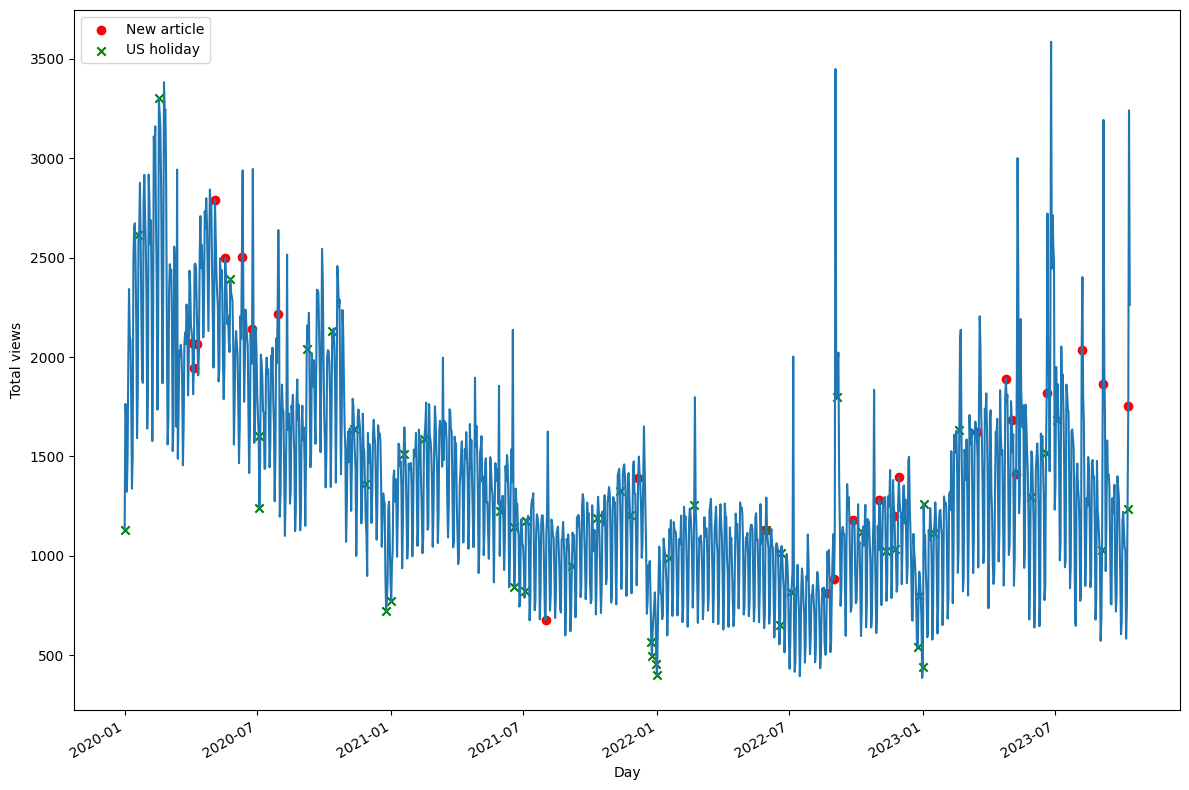

In [ ]:
published_dates = df[df['published'] == 1]
holidays = df[df['is_holiday'] == 1]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df['ds'], df['y'])
ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red', label='Articulos nuevos')
ax.scatter(holidays['ds'], holidays['y'], marker='x', color='green', label='feriado en estados unidos')
ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')

fig.autofmt_xdate()


plt.tight_layout()

En la figura anterior, podemos ver una estacionalidad semanal, con más visitas entre semana que durante el fin de semana.

In [ ]:
train = df[:-28]
test = df[-28:]

print(train.shape, test.shape)

(1353, 5) (28, 5)


In [ ]:
# Cree un marco de datos futuro con valores de variables exógenas. Eliminando la columna y del dataframe

future_df = test.drop(['y'], axis=1)
future_df.head()

,unique_id,ds,published,is_holiday
1353,0,2023-09-15,0.0,0
1354,0,2023-09-16,0.0,0
1355,0,2023-09-17,0.0,0
1356,0,2023-09-18,0.0,0
1357,0,2023-09-19,0.0,0


Este código define una lista de modelos de pronóstico de series de tiempo, cada uno configurado con diferentes arquitecturas y parámetros específicos para manejar variables exógenas, escalamiento de datos y características del modelo como capas, tamaños de entrada y horizonte de predicción.

In [ ]:
horizon = len(test)

models = [
    NHITS(
        h=horizon,
        input_size = 5*horizon,
        futr_exog_list=['published', 'is_holiday'],
        hist_exog_list=['published', 'is_holiday'],
        scaler_type='robust'),
    BiTCN(
        h=horizon,
        input_size=5*horizon,
        futr_exog_list=['published', 'is_holiday'],
        hist_exog_list=['published', 'is_holiday'],
        scaler_type='robust'),
    PatchTST(
        h=horizon,
        input_size=2*horizon,
        encoder_layers=3,
        hidden_size=128,
        linear_hidden_size=128,
        patch_len=4,
        stride=1,
        revin=True,
        max_steps=1000
    )
]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
# Esta linea demora mucho tiempo de ejecucion. Aqui se configura y entrena los modelos enunciados anterioirmente en los datos de entrenamiento.
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.4 M  | train
-------------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.521    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | MAE           | 0      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 96     | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 8.6 K  | train
6  | lin_futr      | Linear        | 48     | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 8.6 K  | train
9  | drop_temporal | Dropout       | 0    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 499 K  | train
-----------------------------------------------------------
499 K     Trainable params
3         Non-trainable params
499 K     Total params
1.999     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


In [ ]:
# Aqui se usa los modelos entrenados para hacer predicciones sobre datos futuros

preds_df = nf.predict(futr_df=future_df)
preds_df.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,NHITS,BiTCN,PatchTST
unique_id,,,,
0,2023-09-15,975.478760,1247.296143,1207.986572
0,2023-09-16,518.049805,805.193481,779.961792
0,2023-09-17,1018.463867,1022.404480,974.505249
0,2023-09-18,1450.590576,1541.200317,1589.797241
0,2023-09-19,1488.419067,1597.259399,1605.498169


In [ ]:
test_df = pd.merge(test, preds_df, 'left', 'ds')
test_df

,unique_id,ds,y,published,is_holiday,NHITS,BiTCN,PatchTST
0,0,2023-09-15,1082,0.0,0,975.478760,1247.296143,1207.986572
1,0,2023-09-16,758,0.0,0,518.049805,805.193481,779.961792
2,0,2023-09-17,755,0.0,0,1018.463867,1022.404480,974.505249
3,0,2023-09-18,1290,0.0,0,1450.590576,1541.200317,1589.797241
4,0,2023-09-19,1214,0.0,0,1488.419067,1597.259399,1605.498169
5,0,2023-09-20,1244,0.0,0,1497.469604,1544.198364,1678.770996
6,0,2023-09-21,1357,0.0,0,1625.949097,1558.084106,1611.585938
7,0,2023-09-22,915,0.0,0,1322.972046,1230.268066,1526.887817
8,0,2023-09-23,719,0.0,0,856.311096,788.832031,996.139771
9,0,2023-09-24,807,0.0,0,1097.437744,975.528564,1038.571289


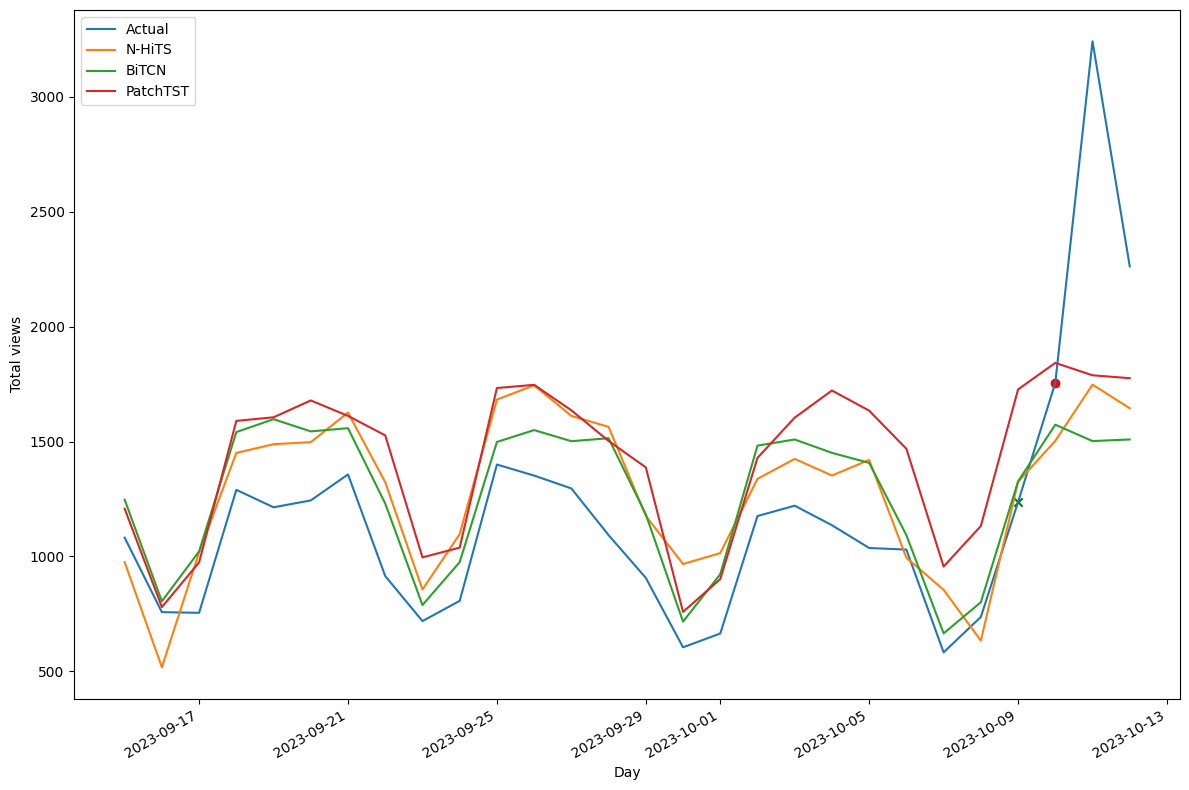

In [ ]:
# Aqui se ven los valores reales junto con las predicciones de varios modelos , los dias de publicaciones y festivos

published_dates = test_df[test_df['published'] == 1]
holidays = test_df[test_df['is_holiday'] == 1]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(test_df['ds'], test_df['y'], label='Actual')
ax.plot(test_df['ds'], test_df['NHITS'], label='N-HiTS')
ax.plot(test_df['ds'], test_df['BiTCN'], label='BiTCN')
ax.plot(test_df['ds'], test_df['PatchTST'], label='PatchTST')
ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red')
ax.scatter(holidays['ds'], holidays['y'], marker='x', color='green')
ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')

fig.autofmt_xdate()


plt.tight_layout()

In [ ]:
# Se evalua el rendimiento de los modelos y resalta en azul los modelos con mejor rendimiento en cada métrica.


from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=["NHITS", "BiTCN", "PatchTST"],
    target_col="y",
)

evaluation = evaluation.drop(['unique_id'], axis=1)
evaluation = evaluation.set_index('metric')

evaluation.style.highlight_min(color='blue', axis=1)

,NHITS,BiTCN,PatchTST
metric,,,
mae,309.732533,285.385097,384.283487
smape,0.123591,0.105171,0.145781
